In [1]:
#pip install tqdm

In [2]:
#pip install segmentation-models

In [27]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import cv2
import glob
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%reload_ext tensorboard

import albumentations as A
import random
from skimage.io import imread, imshow
from skimage import io, img_as_ubyte
from PIL import Image
from sklearn.utils import shuffle

import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte
from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Model, Input
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
#from keras.layers import concatenate

from sklearn.utils import class_weight
from keras.losses import binary_crossentropy
#import scikitplot as skplt

from segmentation_models.losses import bce_jaccard_loss
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models.losses import binary_focal_loss

from segmentation_models import Unet

## Loss Functions & Metrics

In [28]:
#LOSS FUNCTIONS

#Jacquard Loss
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

#Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Binary Cross Entropy
binary_ce = tf.keras.losses.BinaryCrossentropy()

#Weighted Binary Cross Entropy
def weighted_bce(y_true, y_pred):
    num_pred = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) + K.sum(y_true)
    zero_weight =  K.sum(y_true)/ num_pred +  K.epsilon() 
    one_weight = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) / num_pred +  K.epsilon()
    weights =  (1.0 - y_true) * zero_weight +  y_true * one_weight 
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)
    weighted_bin_crossentropy = weights * bin_crossentropy 
    return K.mean(weighted_bin_crossentropy)

#Focal Loss
def binary_focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(p_t)
    weight = alpha_t * K.pow((1-p_t), gamma)
    loss = weight * cross_entropy
    focal_loss = K.sum(loss, axis=1)
    return focal_loss

#Tversky Loss
def binary_tversky_loss(y_true, y_pred, beta=0.7, smooth=1.0):
    axis_to_reduce = range(1, K.ndim(y_pred)) 
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce) 
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  
    denominator = K.sum(denominator, axis=axis_to_reduce)
    tversky_coeff = (numerator + smooth) / (denominator + smooth)  
    return 1-tversky_coeff

# def dice_loss(y_true, y_pred, ,beta = 0.5, smooth = 1.0): #Same as Tversky Loss but with Beta = 0.5
#     axis_to_reduce = range(1, K.ndim(y_pred)) 
#     numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  
#     denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  
#     denominator = K.sum(denominator, axis=axis_to_reduce)
#     tversky_coeff = (numerator + smooth) / (denominator + smooth)  
#     return 1-tversky_coeff

#Focal Tversky Loss
def focal_tversky(y_true, y_pred):
    epsilon = 1e-5
    smooth = 1.
    alpha = 0.7
    gamma = 0.75
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    tversky = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return K.pow((1-tversky), gamma)

#Combo Loss
def combo_loss(y_true, y_pred, smooth=1):
    e = K.epsilon()
    if y_pred.shape[-1] <= 1:
        ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
        CE_RATIO = 0.5 # weighted contribution of modified CE loss compared to Dice loss
        y_pred = tf.keras.activations.sigmoid(y_pred)
    elif y_pred.shape[-1] >= 2:
        ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
        CE_RATIO = 0.7 # weighted contribution of modified CE loss compared to Dice loss
        y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
        y_true = K.squeeze(y_true, 3)
        y_true = tf.cast(y_true, "int32")
        y_true = tf.one_hot(y_true, num_class, axis=-1)
 
 # cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
 
    targets = K.flatten(y_true)
    inputs = K.flatten(y_pred)
 
    intersection = K.sum(targets * inputs)
    dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    inputs = K.clip(inputs, e, 1.0 - e)
    out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
    weighted_ce = K.mean(out, axis=-1)
    combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

    return combo

In [29]:
#METRICS
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true,y_pred):
    inters = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * inters + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1)
    return dice

def recall_m(y_true, y_pred):
    #AKA Sensitivity
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

miou = tf.keras.metrics.MeanIoU(num_classes=2)
#miou = segmentation_models.metrics.iou_score
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def specificity(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

## Generating Training, Testing & Validation Sets

In [30]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#for 10x
TRAIN_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Training Set/'   #for 10x
TEST_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Test Set/'        #for 10x
#AUG_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Augmented_1250/'

train_ids = os.listdir(TRAIN_PATH + 'original/')   #for 10x
test_ids = os.listdir(TEST_PATH + 'original/')     #for 10x
#val_ids =  os.listdir(AUG_PATH + 'Original/')

#for 40x
#TRAIN_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_40x/Train set/'   #for 40x
#TEST_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_40x/Test set/'     #for 40x

#train_ids = os.listdir(TRAIN_PATH + 'org_patches/')   #for 40x
#test_ids = os.listdir(TEST_PATH + 'org/')   #for 40x

In [31]:
print('Resizing training images and masks')
X_train = []
Y_train = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
   img = imread(TRAIN_PATH + '/original/' + id_)   #for 10x
  # img = imread(TRAIN_PATH + '/org_patches/' + id_)   #for 40x
   X_train.append(img)
   mask = imread(TRAIN_PATH + '/Mask/' + id_ )   #for 10x
  # mask = imread(TRAIN_PATH + '/Mask_patches/' + id_ )   #for 40x
   Y_train.append((mask/ 255).reshape(256, 256, 1))

  1%|          | 10/1211 [00:00<00:12, 98.86it/s]

Resizing training images and masks


100%|██████████| 1211/1211 [00:03<00:00, 341.23it/s]


In [32]:
print('Resizing test images and masks')

X_test = []
Y_test = []


#os.chdir('/content/drive/MyDrive/Data')       

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
  img1 = imread(TEST_PATH + '/original/' + id_ )   #for 10x

 # img1 = imread(TEST_PATH + '/org/' + id_ )         #for 40x 
  X_test.append(img1)

  mask1 = imread(TEST_PATH  + '/Mask/' + id_ )    #for 10x
    
 # mask1 = imread(TEST_PATH  + '/mask/' + id_ )     #for 40x     
  Y_test.append((mask1/ 255).reshape(256, 256, 1))
    
X_train = np.array(X_train)/255
Y_train = np.array(Y_train)
X_test = np.array(X_test)/255
Y_test = np.array(Y_test)

  5%|▍         | 15/303 [00:00<00:02, 137.45it/s]

Resizing test images and masks


100%|██████████| 303/303 [00:00<00:00, 344.06it/s]


In [8]:
#60-20-20 split (908 training-303 validation -303 testing)
#full_train_label = np.copy(Y_trainf)
#val_set_len = 303
#val_train = []
#val_test = []

#for i in range(val_set_len):
 #   index = random.randint(0, len(X_trainf)-1)
  #  val_train.append(X_trainf[index])
   # X_trainf.pop(index)
    #val_test.append(Y_trainf[index])
    #Y_trainf.pop(index)
    
#print(len(X_trainf))
#print(len(val_train))

#X_train = np.array(X_trainf)/255
#Y_train = np.array(Y_trainf)
#X_test = np.array(X_test)/255
#Y_test = np.array(Y_test)
#val_train = np.array(val_train)/255
#val_test = np.array(val_test)

908
303


In [10]:
# print('Resizing test images and masks')
# X_testf = []
# Y_testf = []
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#   img1 = imread(TEST_PATH + '/original/' + id_ )
#   X_testf.append(img1)
#   mask1 = imread(TEST_PATH  + '/Mask/' + id_ )
#   Y_testf.append((mask1/ 255).reshape(256, 256, 1))

In [11]:
# print('Resizing Augmented images and masks')
# X_aug = []
# Y_aug = []
# id_list = []
# for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
#     id_list.append(id_)
#     if id_ != '.ipynb_checkpoints':
#         img2 = imread(AUG_PATH + '/Original/' + id_ )
#         X_aug.append(img2)
#         mask2 = imread(AUG_PATH  + '/Mask/' + id_ )
#         Y_aug.append((mask2/ 255).reshape(256, 256, 1))

### 70-15-15 Split

In [12]:
# #1. Split Original Training Split to get Validation set (+ Extra Testing set) elements
# #2. Combine Augmented set with leftover Training set
# #3. Shuffle above set to get new Training Set 
# #4. Remove validation_split in model.fit and replace it with validation_data

# # : 70-15-15 Split

# val_set_len = 415
# val_train = []
# val_test = []

# for i in range(val_set_len):
#     index = random.randint(0, len(X_trainf)-1)
#     val_train.append(X_trainf[index])
#     X_trainf.pop(index)
#     val_test.append(Y_trainf[index])
#     Y_trainf.pop(index)
    
# print(len(X_trainf))
# print(len(val_train))

# extra_test_img = 112
# for j in range(extra_test_img):
#     index2 = random.randint(0, len(X_trainf)-1)
#     X_testf.append(X_trainf[index2])
#     X_trainf.pop(index2)
#     Y_testf.append(Y_trainf[index2])
#     Y_trainf.pop(index2)
    
# print(len(X_trainf))
# print(len(val_train))
    
# #Final Training Set
# X_train_o = X_trainf + X_aug
# Y_train_o = Y_trainf + Y_aug

# print(len(X_train_o))
# print(len(Y_train_o))
    
# X_train = np.array(X_train_o)/255
# Y_train = np.array(Y_train_o)
# X_test = np.array(X_testf)/255
# Y_test = np.array(Y_testf)
# val_train = np.array(val_train)/255
# val_test = np.array(val_test)

In [33]:
Y_train  = Y_train[:,:,:,0]
Y_test  = Y_test[:,:,:,0]
#val_test = val_test[:,:,:,0]

In [34]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (1211, 256, 256, 3)
Y_train = (1211, 256, 256)
X_test  = (303, 256, 256, 3)
Y_test  = (303, 256, 256)


### Plotting Training Images

In [35]:
def plotImages(images_arr, num_plots = 5):
    fig, axes = plt.subplots(1, num_plots, figsize=(30, 30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

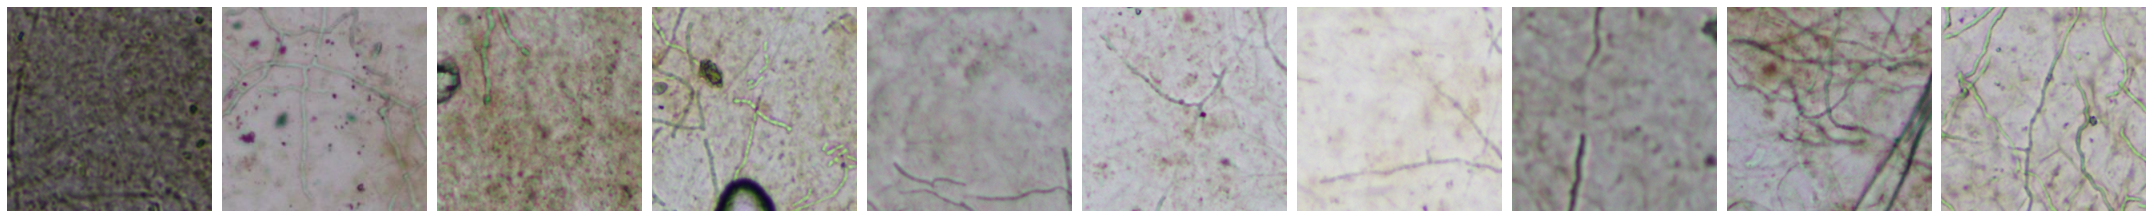

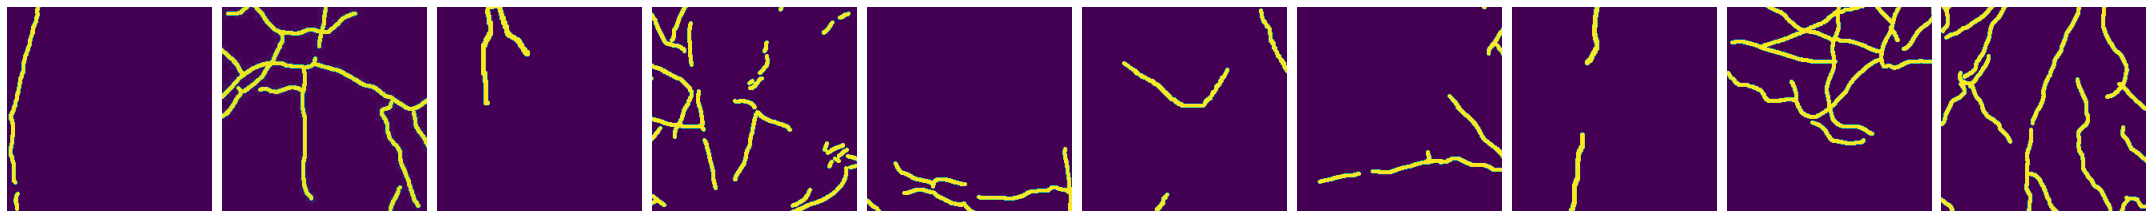

In [36]:
# plot images
plotImages(X_train,10)
plotImages(Y_train,10)

## Training the Model

# RESUNET - Zhengxin Zhang

In [37]:
df = pd.DataFrame()
col_names = ['Model', 'History', 'LR', 'BATCH', 'es_patience', 'es_mindelta', 'rlr_patience', 'rlr_mindelta']
df = pd.DataFrame(columns=col_names)

In [38]:
#PARAMETERS
LR = 0.001
fname_model = 'resunet_trial_bce_10x.h5'
fname_history = 'history_resunet3_trial_bce_10x.csv'
es_mindelta = 0.001
es_patience  = 6
rlr_patience = 3
rlr_mindelta = 0.001
BATCH = 16

entry = [fname_model, fname_history, LR, BATCH, es_patience, es_mindelta, rlr_patience, rlr_mindelta]

In [39]:
#BLOCKS
def bn_act(x, act=True):
    x = layers.BatchNormalization()(x)
    if act == True:
        x = layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = layers.UpSampling2D((2, 2))(x)
    c = layers.Concatenate()([u, xskip])
    return c

In [40]:
#RESUNET
image_size = 256
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs)
        
    adam=tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer = adam, loss = [binary_ce], metrics = [jacard_coef, f1_m, precision_m, recall_m, dice_coef, 'accuracy', specificity])
    #model.summary()
    
    return model

In [41]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('resunet_trial_bce_10x_check.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = es_patience, monitor='val_loss', min_delta=es_mindelta)
#tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose = 1, min_delta=rlr_mindelta, factor = 0.01, patience =rlr_patience, mode='min', min_lre =  0.00001)
                                                 
callbacks = [
              checkpointer,
               earlystopper, reduce_LR
            ]
##############
model = ResUNet()
##############
history1  = model.fit(X_train, Y_train
                    , batch_size=16
                    , epochs=200
                    , validation_split=0.3
                    , shuffle=True
                    #validation_data=(val_train, val_test)
                    #, class_weight=weights
                    # , use_multiprocessing=True
                    , verbose = 1
                    , callbacks=callbacks
                   )

Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.1975 - jacard_coef: 0.1416 - f1_m: 0.2331 - precision_m: 0.5519 - recall_m: 0.1776 - dice_coef: 0.4284 - accuracy: 0.9267 - specificity: 0.9402
Epoch 00001: val_loss improved from inf to 0.98657, saving model to resunet_trial_bce_10x_check.h5
53/53 [==============================] - 15s 285ms/step - loss: 0.1975 - jacard_coef: 0.1416 - f1_m: 0.2331 - precision_m: 0.5519 - recall_m: 0.1776 - dice_coef: 0.4284 - accuracy: 0.9267 - specificity: 0.9402 - val_loss: 0.9866 - val_jacard_coef: 0.0027 - val_f1_m: 0.0068 - val_precision_m: 0.0650 - val_recall_m: 0.0036 - val_dice_coef: 0.2309 - val_accuracy: 0.9295 - val_specificity: 0.9973
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.1446 - jacard_coef: 0.1957 - f1_m: 0.3766 - precision_m: 0.6266 - recall_m: 0.2766 - dice_coef: 0.5059 - accuracy: 0.9420 - specificity: 0.9560
Epoch 00002: val_loss improved from 0.98657 to 0.86850, saving model to res

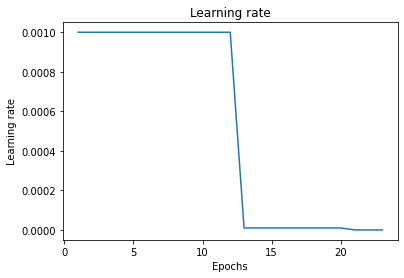

In [42]:
hist = history1.history
def plot_lr(history):
    learning_rate = history1.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()
    
plot_lr(history1)

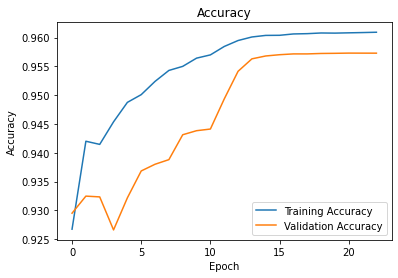

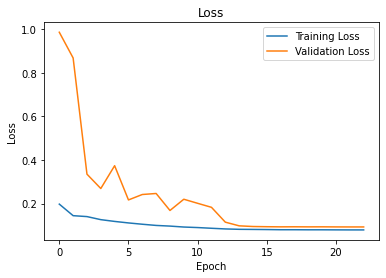

In [43]:
#Accuracy Curve
plt.figure()
plt.plot(hist['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.figure(1)
plt.plot(hist['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")


#Loss Curve
plt.figure()
plt.plot(hist['loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(hist['val_loss'][:])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
plt.show()

In [44]:
#Saving Model
file_name_m = f'/home/keerthanaprasad/RajithaKV/Data_256_Unet/{fname_model}'
model.save(file_name_m)
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history1.history) 
hist_csv_file = fname_history
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [45]:
#Append new model to df
df.loc[len(df)] = entry

# Drop Entry
# df = df.drop(1)

#Saving Df as CSV
# df.to_csv('file1.csv')
df

,Model,History,LR,BATCH,es_patience,es_mindelta,rlr_patience,rlr_mindelta
0,resunet_trial_bce_10x.h5,history_resunet3_trial_bce_10x.csv,0.001,16,6,0.001,3,0.001


# Evaluating

In [46]:
from keras.models import load_model
# model.load_weights('/home/keerthanaprasad/RajithaKV/Data_256_Unet/resunet_foc.h5') 
# new_model = load_model('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unet_ronn_bce3.h5',custom_objects={'jacard_coef_loss':jacard_coef_loss, 
#                                                                                                          'jacard_coef': jacard_coef, 'f1_m':f1_m, 'precision_m':precision_m, 
#                                                                                                          'recall_m':recall_m, 'dice_coef':dice_coef, 'specificity':specificity, 'binary_focal_loss':binary_focal_loss, ' iou_score': iou_score })
new_model = model

In [22]:
#Selecting Appropriate Threshold (as per highest Jaccard Score) --> Using Validation set
preds_val_test = new_model.predict(val_train, verbose=1)

def to_labels(probs, threshold):
    a = (probs > threshold).astype(np.uint8)
    a = a.astype(float)
    return a.flatten()

thresholds = np.arange(0, 1, 0.01) #100 terms
scores = []

print('\n---Finding Threshold---')
for t in tqdm(thresholds):
    scores.append(np.around(jacard_coef(val_test.flatten(), to_labels(preds_val_test,t)),3))
ix = np.argmax(scores)
print('Threshold=%.3f, Jaccard Coef.=%.5f' % (thresholds[ix], scores[ix]))

NameError: name 'val_train' is not defined

In [47]:
preds_test = new_model.predict(X_test, verbose=1)
#Thresholding
#preds_test_t = (preds_test>thresholds[ix]).astype(np.uint8)
preds_test_b = (preds_test>0.5).astype(np.uint8) #Default threshold = 0.5

10/10 [==============================] - 1s 115ms/step


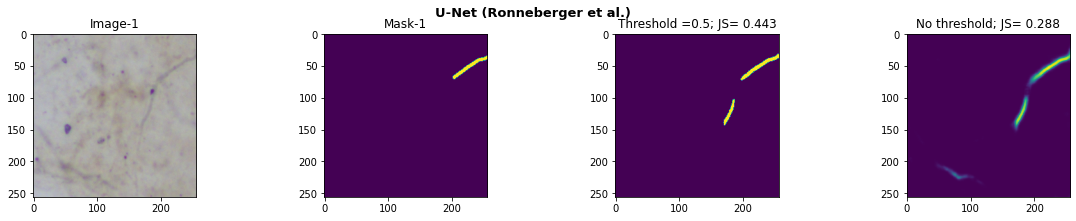

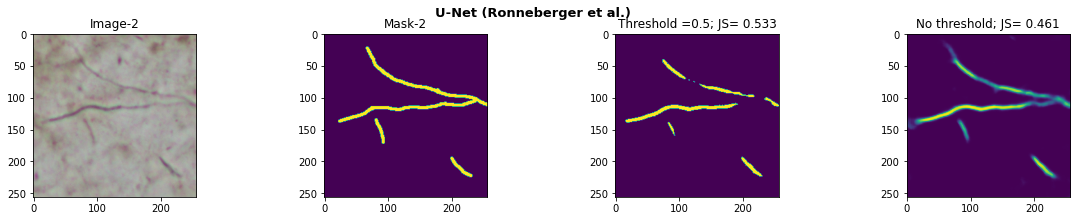

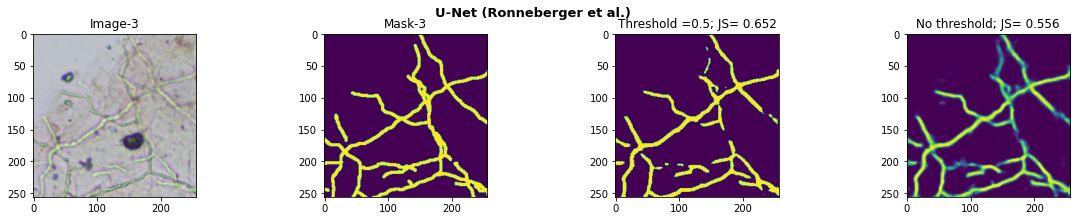

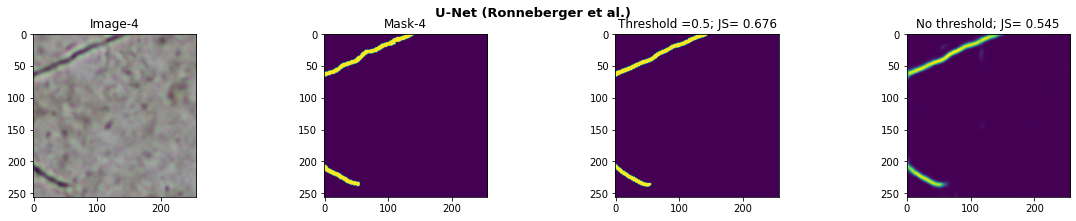

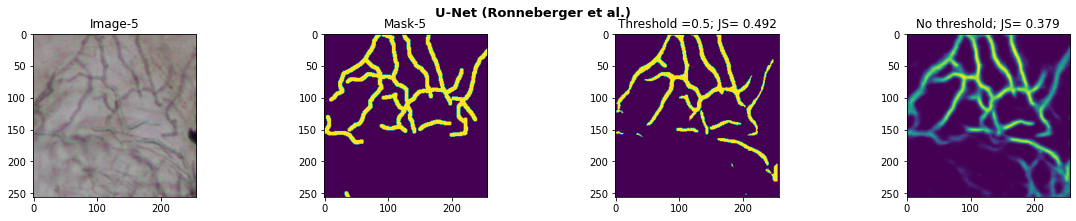

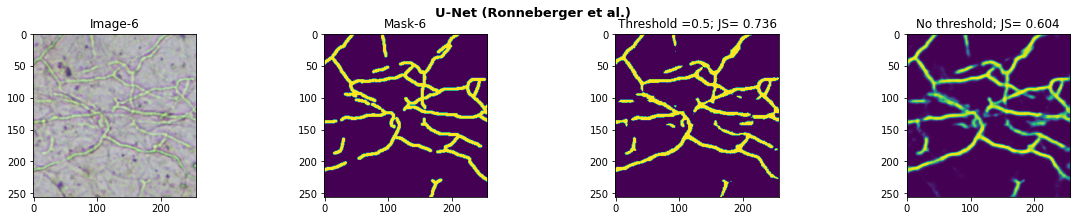

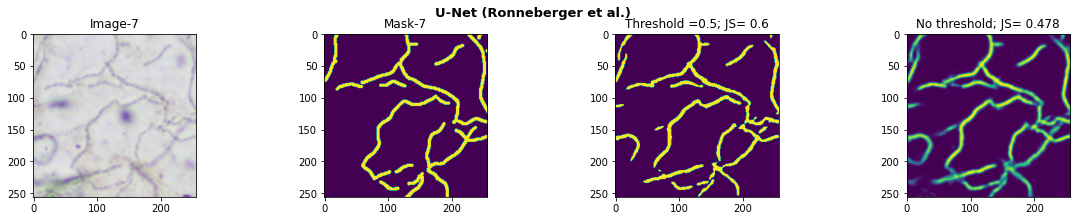

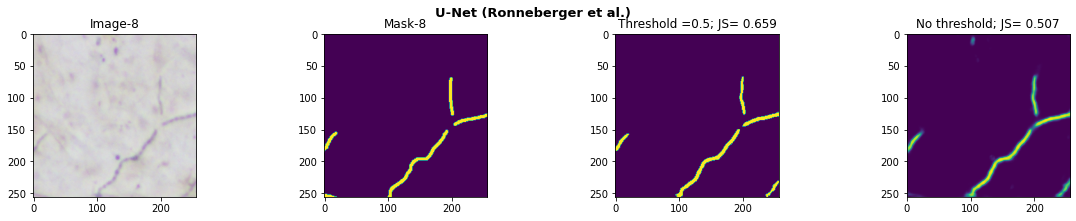

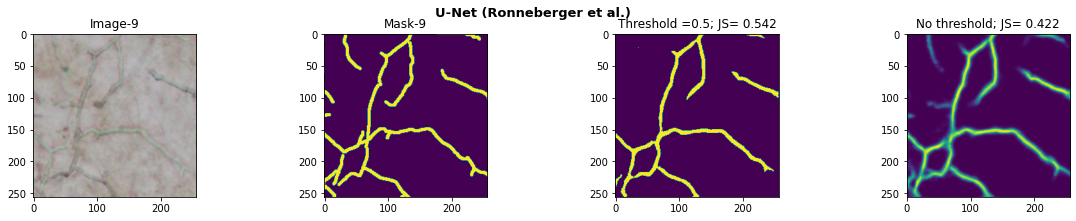

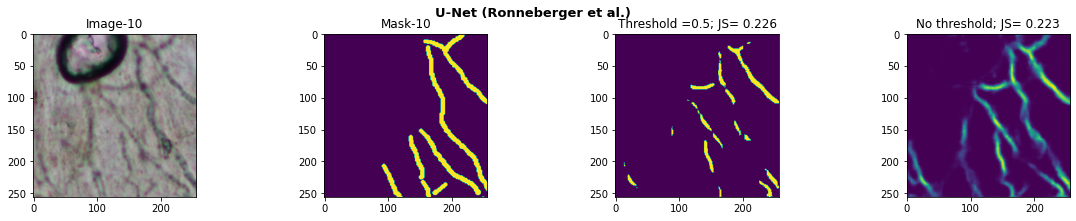

In [48]:
#preds_test_t = (preds_test > 0.35).astype(np.uint8)
#preds_test_t = preds_test_t.astype(float)
preds_test_b = preds_test_b.astype(float)
preds_test=preds_test.astype(float)
#for i in range(len(Y_test)):
for i in range(10):
    plt.figure(figsize=(20,3))
    #if i==1:
    plt.suptitle('U-Net (Ronneberger et al.)', fontsize = 13, fontweight="bold", y=1.005)
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title(f'Image-{i+1}')
    plt.subplot(1,4,2)
    plt.imshow(Y_test[i])
    plt.title(f'Mask-{i+1}')
    #plt.subplot(1,5,3)
    #plt.imshow(preds_test_t[i,:,:,0])
    #plt.title(f'Threshold ={round(thresholds[ix], 2)}; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test_t[i,:,:,0]), 3)))
    plt.subplot(1,4,3)
    plt.imshow(preds_test_b[i,:,:,0])
    plt.title('Threshold =0.5; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test_b[i,:,:,0]), 3)))
    plt.subplot(1,4,4)
    plt.imshow(preds_test[i,:,:,0])
    plt.title('No threshold; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test[i,:,:,0]), 3)))
#     plt.savefig(f"/home/keerthanaprasad/RajithaKV/Baseline Model Images/U-Net (BCE)/unet_{i+1}.png")

In [ ]:
# from sklearn.metrics import roc_curve
# y_preds = preds_test.ravel()
# y_test = Y_test.ravel()
# fpr, tpr, thresholds = roc_curve(y_test, y_preds, pos_label = 2)
# # plt.figure(1)
# # plt.plot([0,1], [0,1], 'y--')
# # plt.plot(fpr,tpr, markers='.')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve')
# # plt.show()


In [ ]:
# from sklearn.utils.multiclass import type_of_target
# print(type_of_target(y_test))
#print(type_of_target(y_preds))

In [49]:
print("Shapes :\n======\nY_test = {}\npreds_test_t = {}"
      .format(Y_test.shape, preds_test_b.shape))

Shapes :
Y_test = (303, 256, 256)
preds_test_t = (303, 256, 256, 1)


In [50]:
# evaluate model
mtrics = new_model.evaluate(X_test, Y_test)
print("Accuracy = ", (mtrics[6]*100), "%")
print("Jacard Score = ", (mtrics[1]*100), "%")
print("F1 Score = ", (mtrics[2]*100), "%")
print("Precision = ", (mtrics[3]*100), "%")
print("Recall  = ", (mtrics[4]*100), "%")
print("Specificity = ",(mtrics[7]*100),"%")
print("Dice Score  = ", (mtrics[5]*100), "%")
#print("MIOU  = ", (mtrics[8]*100), "%")


10/10 [==============================] - 1s 102ms/step - loss: 0.0855 - jacard_coef: 0.4130 - f1_m: 0.6808 - precision_m: 0.7434 - recall_m: 0.6287 - dice_coef: 0.7351 - accuracy: 0.9610 - specificity: 0.9745
Accuracy =  96.09719514846802 %
Jacard Score =  41.300565004348755 %
F1 Score =  68.07535886764526 %
Precision =  74.34252500534058 %
Recall  =  62.87413239479065 %
Specificity =  97.45071530342102 %
Dice Score  =  73.50532412528992 %


In [51]:
metric = tf.keras.metrics.MeanIoU(num_classes=2)
print(metric(preds_test, Y_test))

tf.Tensor(0.47076687, shape=(), dtype=float32)
